In [258]:
import os
import torch
from trainers.torch.networks import SplitValueSharedActorCritic
from mlagents_envs.base_env import ObservationSpec, DimensionProperty, ObservationType
from mlagents.trainers.settings import NetworkSettings, TrainerSettings
from mlagents_envs.base_env import ActionSpec
from trainers.policy.torch_policy import TorchPolicy
from mlagents_envs.base_env import BehaviorSpec

In [259]:
run_name="4-22-ppo-0"
load_path = f"/home/rmarr/Projects/visibility-game-env/results/{run_name}/Seeker/checkpoint.pt"
saved_state_dict = torch.load(load_path)

In [260]:
seed = 5404
observation_specs = [ObservationSpec(
            name="position_observation",
            shape=(12,),  # 3D vector
            dimension_property=(DimensionProperty.NONE,),  # Must be a tuple
            observation_type=ObservationType.DEFAULT
        )]
action_spec = ActionSpec(
    continuous_size=0,
    discrete_branches=(5,)
)
behavior_spec = BehaviorSpec(
    observation_specs=observation_specs,
    action_spec=action_spec
)
trainer_settings = TrainerSettings(
    dual_critic=True
)
network_settings = NetworkSettings(
    deterministic=False,
    memory=None,
    hidden_units=128,
    num_layers=2,
)

stream_names = ["default"]
conditional_sigma = False
tanh_squash = False
load_critic_only = "position_only"

In [261]:
policy = TorchPolicy(
    seed=seed,
    behavior_spec=behavior_spec,
    trainer_settings=trainer_settings,
    tanh_squash=False,
    separate_critic=False,
    condition_sigma_on_obs=False,
    load_critic_only=load_critic_only
)

separate_critic: False


In [262]:
modules = policy.get_modules()

In [263]:
for opt in saved_state_dict['Optimizer:critic']:
    print(opt)
    print(saved_state_dict['Optimizer:critic'][opt] == saved_state_dict['Policy'][opt])
    # == saved_state_dict['Policy']

version_number
tensor([True])
is_continuous_int_deprecated
tensor([True])
continuous_act_size_vector
tensor([True])
discrete_act_size_vector
tensor([[True]])
act_size_vector_deprecated
tensor([True])
memory_size_vector
tensor([True])
network_body._body_endoder.seq_layers.0.weight
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
network_body._body_endoder.seq_layers.0.bias
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, Tr

In [264]:
position_state_dict = {k: v for k, v in saved_state_dict['Optimizer:critic'].items() if 'position_network' in k or 'value_heads' in k}
importance_network_path = "/home/rmarr/Projects/visibility-game-env/informed_init/bias_importance.pt"
importance_state_dict = torch.load(importance_network_path)

In [265]:
#modules['Policy'].load_state_dict(position_state_dict, strict=False)
modules['Policy'].load_state_dict(saved_state_dict['Policy'], strict=True)
#modules['Policy'].load_state_dict(importance_state_dict, strict=False)

<All keys matched successfully>

In [266]:
positions = []
for y in range(-4, 26, 1):
    for x in range(-4, 26, 1):
        positions.append([x-0.5, 0.5, y-0.5] + [0]*9)
positions = [torch.tensor(positions)]

In [267]:
len(positions[0])

900

In [268]:
#policy.actor.critic_pass_position([torch.tensor([[8.5, 0.5, 2.5]])])[0]['extrinsic']

In [275]:
vals = policy.actor.critic_pass(positions)[0]['extrinsic']

In [276]:
vals.shape

torch.Size([900])

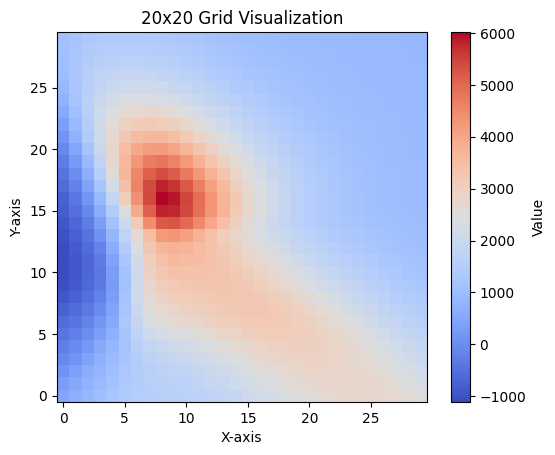

In [277]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'vals' is your tensor of 400 values
vals_np = vals.detach().cpu().numpy()  # Convert tensor to numpy array

# Reshape the values into a 20x20 grid
grid = vals_np.reshape((30, 30))

# Create a colormap with a gradient from blue (min) to red (max)
cmap = plt.get_cmap('coolwarm')

# Plot the heatmap
plt.imshow(grid, cmap=cmap, origin='lower')

# Add a color bar to show the scale
plt.colorbar(label='Value')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('20x20 Grid Visualization')

# Show the plot
plt.show()

In [272]:
grid

array([[ 2.57636078e+02,  5.51542297e+02,  8.41514709e+02,
         1.12393872e+03,  1.41031555e+03,  1.63318738e+03,
         1.75055054e+03,  1.80364954e+03,  1.85213892e+03,
         1.87343518e+03,  1.90154883e+03,  1.95550220e+03,
         2.03444971e+03,  2.12729834e+03,  2.23079810e+03,
         2.34399463e+03,  2.46659155e+03,  2.59792310e+03,
         2.73644922e+03,  2.87807764e+03,  3.02119019e+03,
         3.16600049e+03,  3.31148999e+03,  3.45715479e+03,
         3.60281641e+03,  3.74847925e+03,  3.89424414e+03,
         4.04025098e+03,  4.18663379e+03,  4.33350000e+03],
       [-1.22235088e+01,  3.65264832e+02,  6.69428284e+02,
         9.86757263e+02,  1.30535547e+03,  1.57035962e+03,
         1.72936560e+03,  1.81268555e+03,  1.87857080e+03,
         1.93298853e+03,  1.98867688e+03,  2.07018408e+03,
         2.16909937e+03,  2.28110010e+03,  2.40435352e+03,
         2.53709985e+03,  2.67714355e+03,  2.82202637e+03,
         2.96741528e+03,  3.11353955e+03,  3.26050366e+

In [273]:
grid.shape

(30, 30)

In [274]:
# In[22]: Fit a multicomponent GMM to your 29×29 grid
import numpy as np
from sklearn.mixture import GaussianMixture

# 1) Reconstruct the (x,y) positions from your grid indices
#    You originally did: for y in range(-4,25), x in range(-4,25): pos = [x-0.5, 0.5, y-0.5]
#    We only need the (x,y) plane here:
xs = np.arange(-4, 25) - 0.5   # length = 29
ys = np.arange(-4, 25) - 0.5   # length = 29
xx, yy = np.meshgrid(xs, ys, indexing="xy")
pos2 = np.stack([xx.ravel(), yy.ravel()], axis=1)  # shape = (841, 2)

# 2) Flatten your grid of values (shape = (29,29)) into weights w (shape = (841,))
w = grid.flatten().clip(min=0)   # ensure non‑negative weights
if w.sum() <= 0:
    raise ValueError("All grid values are non‑positive!")

# Choose how many Gaussian components you want:
K = 3

# ───────────────────────────────────────────────────
# Approach A: Directly pass sample_weight (sklearn ≥0.20)
# ───────────────────────────────────────────────────
gmm_direct = GaussianMixture(
    n_components=K,
    covariance_type="full",
    random_state=0,
)
# this requires scikit‑learn >= 0.20
gmm_direct.fit(pos2, w)

print("Direct GMM fit:")
print("  weights:", gmm_direct.weights_)
print("  means:  \n", gmm_direct.means_)
print("  covars: \n", gmm_direct.covariances_)


# ───────────────────────────────────────────────────
# Approach B: Bootstrapped resampling (for older sklearn)
# ───────────────────────────────────────────────────
def fit_gmm_by_resampling(pos2, w, n_components=3, n_samples=20_000, seed=None):
    """
    Approximate weighted GMM by drawing samples with probability ∝ w.
    Returns a fitted GaussianMixture object.
    """
    rng = np.random.default_rng(seed)
    p = w / w.sum()
    idxs = rng.choice(len(pos2), size=n_samples, p=p)
    pos_rs = pos2[idxs]
    gm = GaussianMixture(
        n_components=n_components,
        covariance_type="full",
        random_state=seed,
    )
    gm.fit(pos_rs)
    return gm

gmm_mc = fit_gmm_by_resampling(pos2, w, n_components=K, n_samples=20_000, seed=42)
print("\nResampled GMM fit:")
print("  weights:", gmm_mc.weights_)
print("  means:  \n", gmm_mc.means_)
print("  covars: \n", gmm_mc.covariances_)

Direct GMM fit:
  weights: [0.32348138 0.34477458 0.33174403]
  means:  
 [[15.56544895 15.68576748]
 [ 1.10172041 11.67645531]
 [12.31377637  1.20635544]]
  covars: 
 [[[26.22573278 -1.45277737]
  [-1.45277737 25.52496362]]

 [[15.13684059  3.56944458]
  [ 3.56944458 57.29738789]]

 [[52.60993792  3.45487431]
  [ 3.45487431 15.55061328]]]


ValueError: a and p must have same size

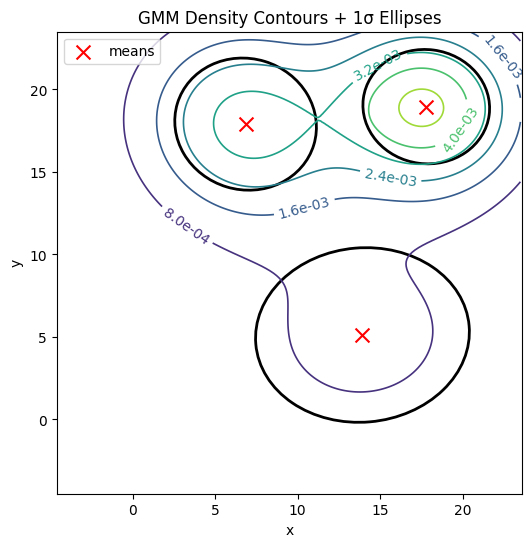

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# — assume you have already:
#    xs, ys    : 1D arrays of your grid‐coords (length 29)
#    gmm       : fitted sklearn.mixture.GaussianMixture with K components

gmm = gmm_mc

# 1) Build a fine mesh over the same x,y span
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()
n_grid = 200
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, n_grid),
    np.linspace(y_min, y_max, n_grid),
)
xy = np.column_stack([xx.ravel(), yy.ravel()])

# 2) Evaluate GMM density
log_dens = gmm_mc.score_samples(xy)        # log‑density at each mesh point
dens = np.exp(log_dens).reshape(xx.shape)

# 3) Plot density contours
plt.figure(figsize=(6,6))
cs = plt.contour(
    xx, yy, dens,
    levels=6,           # number of contour levels
    cmap="viridis",
    linewidths=1.2,
)
plt.clabel(cs, inline=1, fontsize=10, fmt="%.1e")

# 4) Plot 1σ ellipses for each component
for weight, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    # eigen‐decompose cov to get ellipse parameters
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals)   # 1σ → factor=2*sqrt(eigenvalue)
    ell = Ellipse(
        xy=mean,
        width=width, height=height,
        angle=angle,
        edgecolor="black",
        facecolor="none",
        lw=2,
    )
    plt.gca().add_patch(ell)

# 5) Mark component means
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c="red", marker="x", s=100, label="means")

# Finalize
plt.title("GMM Density Contours + 1σ Ellipses")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis("equal")
plt.show()

In [257]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook cell: gaussian_drawer_with_reset.ipynb
# ─────────────────────────────────────────────────────────────────────────────

from ipycanvas import Canvas
from ipywidgets import Button, HBox
from IPython.display import display
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import cm
import math

# ───────────────────────────────────────────────────────────────
# 1) Assumed already in your namespace:
#    xs, ys  : 1D arrays of your original grid (len=29)
#    gmm_mc  : fitted sklearn.mixture.GaussianMixture
# ───────────────────────────────────────────────────────────────

# 2) Precompute the GMM‐density background as RGBA
WIDTH, HEIGHT = 600, 600
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

# Build pixel↔data mapping grid
px = np.linspace(x_min, x_max, WIDTH)
py = np.linspace(y_max, y_min, HEIGHT)   # invert y so canvas‐top = y_max
XX, YY = np.meshgrid(px, py)
XY = np.column_stack([XX.ravel(), YY.ravel()])

logq = gmm_mc.score_samples(XY)
q_img = np.exp(logq).reshape((HEIGHT, WIDTH))
q_norm = (q_img - q_img.min()) / (q_img.max() - q_img.min())
cmap = cm.get_cmap('viridis')
rgba_bg = (cmap(q_norm) * 255).astype(np.uint8)

# 3) Create the canvas and the Reset button
canvas = Canvas(width=WIDTH, height=HEIGHT)
reset_btn = Button(description="🔄 Reset Drawing")
display(HBox([reset_btn]))
display(canvas)

# 4) Interactive state
state   = 0     # 0=await major, 1=dragging major, 2=await minor, 3=dragging minor, 4=done
center  = None
vec1    = None
vec2    = None
startxy = None

def redraw_background():
    """Re‐paint the GMM background."""
    canvas.clear()
    canvas.put_image_data(rgba_bg, 0, 0)

# 5) Mouse callbacks (no 'buttons' arg!)
def on_mouse_down(x, y):
    global state, center, startxy
    if state == 0:
        center  = (x, y)
        startxy = (x, y)
        state   = 1
    elif state == 2:
        startxy = (x, y)
        state   = 3

def on_mouse_move(x, y):
    if state not in (1, 3):
        return
    redraw_background()
    canvas.stroke_style = 'magenta'
    canvas.line_width   = 2
    # draw first axis if exists
    if vec1 is not None:
        x0, y0 = center
        x1, y1 = x0 + vec1[0], y0 + vec1[1]
        canvas.stroke_line(x0, y0, x1, y1)
    # draw the currently‐dragged axis
    if state == 1:
        canvas.stroke_line(center[0], center[1], x, y)
    else:  # state == 3
        canvas.stroke_line(center[0], center[1], x, y)

def on_mouse_up(x, y):
    global state, vec1, vec2
    if state == 1:
        vec1  = (x - startxy[0], y - startxy[1])
        state = 2
    elif state == 3:
        vec2  = (x - startxy[0], y - startxy[1])
        state = 4
        finalize_drawing()

def finalize_drawing():
    """Compute drawn‐Gaussian, overlay it, and print L2/KL metrics."""
    # convert pixel ←→ data
    def pix2data(vx, vy):
        dx = (x_max - x_min)/(WIDTH-1)
        dy = (y_max - y_min)/(HEIGHT-1)
        return np.array([ x_min + vx*dx,
                          y_max - vy*dy ])

    mu_ds = pix2data(*center)
    p1_ds = pix2data(center[0]+vec1[0], center[1]+vec1[1]) - mu_ds
    p2_ds = pix2data(center[0]+vec2[0], center[1]+vec2[1]) - mu_ds

    s1 = np.linalg.norm(p1_ds); e1 = p1_ds/s1
    s2 = np.linalg.norm(p2_ds); e2 = p2_ds/s2
    cov_draw = s1**2*np.outer(e1,e1) + s2**2*np.outer(e2,e2)

    # safely build the pdf (allow singular)
    rv = multivariate_normal(mean=mu_ds, cov=cov_draw, allow_singular=True)
    dens_p = rv.pdf(XY).reshape((HEIGHT, WIDTH))

    # overlay the drawn Gaussian as semi‐transparent heatmap
    p_norm  = (dens_p - dens_p.min())/(dens_p.max()-dens_p.min())
    rgba_p  = (cmap(p_norm)*255).astype(np.uint8)
    rgba_p[...,3] = 128
    canvas.global_alpha = 0.6
    canvas.put_image_data(rgba_p, 0, 0)
    canvas.global_alpha = 1.0

    # draw the ellipse outline
    import math
    angle_rad = math.atan2(e1[1], e1[0])
    r1 = math.hypot(*vec1)
    r2 = math.hypot(*vec2)

    canvas.stroke_style = 'white'
    canvas.line_width   = 2

    canvas.begin_path()
    canvas.ellipse(
        center[0], center[1],
        r1, r2,
        angle_rad,
        0,             # start angle
        2*math.pi      # end angle
    )
    canvas.stroke()

    # compute errors on the original pixel‐grid
    dx = (x_max - x_min)/(WIDTH-1)
    dy = (y_max - y_min)/(HEIGHT-1)
    area = dx*dy
    p = dens_p.ravel()
    q = q_img.ravel()
    L2 = np.sqrt(np.sum((p-q)**2)*area)
    KL = np.sum(p*(np.log(p+1e-12)-np.log(q+1e-12)))*area

    print(f"L2 error = {L2:.3e}")
    print(f"KL(p‖q)  = {KL:.3e}")

# 6) Start/re‑start function
def start_drawing(*_):
    """Reset state, clear canvas, and re‑attach callbacks."""
    global state, center, vec1, vec2, startxy
    state  = 0
    center = vec1 = vec2 = startxy = None
    redraw_background()
    canvas.on_mouse_down(on_mouse_down)
    canvas.on_mouse_move(on_mouse_move)
    canvas.on_mouse_up(on_mouse_up)
    print("▶ Draw 1st axis by press‐&‐drag, then 2nd axis by press‐&‐drag.")

# hook Reset button
reset_btn.on_click(start_drawing)

# Initial kick‐off
start_drawing()

/tmp/ipykernel_3242914/1375546978.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


Canvas(height=600, width=600)

▶ Draw 1st axis by press‐&‐drag, then 2nd axis by press‐&‐drag.
